# Sorter comparison with ground truth recordings


@author : Samuel Garcia


Giulia  Spampinato from Institut de la Vision, Paris, have publish data from mice retina recorded invitro with from dense array.
The data contain one ground truth to benchmark spike sorting tools. The ground truth is recorded with juxta celullar pipet.

Here the official publication of this open dataset:
https://zenodo.org/record/1205233#.W9mq1HWLTIF


This datasets was used by Pierre Yger publish spyking circus:
https://elifesciences.org/articles/34518


In the original dataset, 19 files are provided.
here we volontary keep only 9 files.
See carrefully the notebook : **prepare_and_check_ground_truth.py.ipynb**






## How to reproduce this notebook


  1. to create a folder **basedir** somwhere.
  2. download all files in zenodo link
  3. put them all in a subfolder **basedir/original_files** (20160415_patch2.tar.gz, ...)
  4. and then execute cells by cell this notebook
  


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spikeextractors as se
import spiketoolkit as st
from spiketoolkit.comparison import (setup_comparison_study, run_study_sorters,
            aggregate_sorting_comparison, aggregate_performances_table)


%matplotlib notebook

15:46:26 [I] klustakwik KlustaKwik2 version 0.2.6
/home/samuel/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/samuel/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## global variables

In [2]:
# my working path
# basedir = '/media/samuel/SamCNRS/DataSpikeSorting/pierre/zenodo/'
# basedir = '/home/samuel/DataSpikeSorting/Pierre/zenodo/'
# basedir = '/mnt/data/sam/DataSpikeSorting/pierre_zenodo/'
basedir = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/Pierre/zenodo/'

# input file
recording_folder = basedir + 'original_files/'

# ground truth information
ground_truth_folder = basedir + 'ground_truth/'

# where output will be
study_folder = basedir + 'study_gt252/'

# sorter list
sorter_list = ['tridesclous']

# selected recordings
rec_names = [ '20160415_patch2', '20170803_patch1', '20170623_patch1', '20170622_patch1', '20160426_patch3', 
            '20170725_patch1', '20170621_patch1', '20160426_patch2', '20170728_patch2']


# Step 1 : detect ground truth on the juxta cellular

This external script:

    * unzip all
    * detect juxta peak
    * make figures to check everything

In [ ]:
%run detect_ground_truth_spike_on_juxta.py

## Step 2 : check groud truth carcteristics

This is done in a separate script to keep this doc simple.

In [3]:
gt_info = pd.read_excel(ground_truth_folder+'gt_info.xlsx', index_col=0)
gt_info.loc[rec_names, :]

,nb_spike,max_on_channel,peak_value,peak_snr,noise_mad
20160415_patch2,3514,69,-407.5,8.866290,45.9606
20170803_patch1,7639,99,-647.5,12.845081,50.4084
20170623_patch1,699,137,-1490.5,38.666480,38.5476
20170622_patch1,4058,176,-410.0,9.218040,44.4780
20160426_patch3,1691,128,-866.5,7.398054,117.1254
20170725_patch1,380,129,-1010.0,27.249427,37.0650
20170621_patch1,4994,99,-947.5,15.587317,60.7866
20160426_patch2,879,230,-894.0,4.466628,200.1510
20170728_patch2,4748,118,-1093.5,22.350171,48.9258


## Step 3: setup study

In this step:
  * we create a dict of (recordings+sorting)
  * and call the function ```setup_comparison_study(study_folder, gt_dict)```

Internanly spiketoolkit copy all recordings and ground truth sorting into a n organised folder.


Important note :
  * the file have 256 channels but only 252 are usefull.
    The PRB file contain all channels needed so we need to explicit **grouping_property='group'**
    to be sure to only take in account the channel in the unique group.
  * This step have to run only once and take some times because of copy.

In [ ]:
gt_dict = {}
for rec_name in rec_names:

    # find raw file
    dirname = recording_folder + rec_name + '/'
    for f in os.listdir(dirname):
        if f.endswith('.raw') and not f.endswith('juxta.raw'):
            mea_filename = dirname + f

    # raw files have an internal offset that depend on the channel count
    # a simple built header can be parsed to get it
    with open(mea_filename.replace('.raw', '.txt'), mode='r') as f:
        offset = int(re.findall('padding = (\d+)', f.read())[0])

    # recording
    rec = se.BinDatRecordingExtractor(mea_filename, 20000., 256, 'uint16', offset=offset, frames_first=True)

    # this reduce channel count to 252
    rec = se.load_probe_file(rec, basedir + 'mea_256.prb')

    # gt sorting
    gt_indexes = np.fromfile(ground_truth_folder + rec_name + '/juxta_peak_indexes.raw', dtype='int64')
    sorting_gt = se.NumpySortingExtractor()
    sorting_gt.set_times_labels(gt_indexes, np.zeros(gt_indexes.size, dtype='int64'))
    sorting_gt.set_sampling_frequency(20000.0)

    gt_dict[rec_name] = (rec, sorting_gt)

setup_comparison_study(study_folder, gt_dict)

# Step 4: run all sorters

spiketoolkit have convinient function for that loop over all recordings and all sorter, compute and save the output sorting into a subfolder.

Note:
  * this can be run several times with other sorter
  * the ```engine='loop'``` prevent to recompute something alreadu computed

In [13]:
run_study_sorters(study_folder, sorter_list, mode='keep', engine='loop')

## Step 4 : collect results

This collect in the folder all output sorting and compare then the ground truth.
Internally it is just a loop and a use of the class ```GroundTruthComparison```.

  * comparisons: contains all GroundTruthComparison
  * dataframes: contains some synthetic dataframes that summary results



In [4]:
%%capture --no-display
comparisons = aggregate_sorting_comparison(study_folder, exhaustive_gt=False)
dataframes = aggregate_performances_table(study_folder, exhaustive_gt=False)

print(comparisons.keys())


## Compare run speed

The speed here are totally wrong because sorters have been launch on several computers.
This is just to show that it is possible.

In [ ]:
run_times = dataframes['run_times']
run_times

In [ ]:
run_times = dataframes['run_times'].reset_index()
fig, ax = plt.subplots()
sns.barplot(data=run_times, x='rec_name', y='run_time', hue='sorter_name', ax=ax)
ax.set_title('Run times')

## Compare global performances

In our case **dataframes['perf_pooled_with_sum']**,  **dataframes['perf_pooled_with_average']** and **dataframes['perf_by_spiketrain']** because there is only one unique ground truth cells per recordings we will call it perfs.

In [6]:
perfs = dataframes['perf_by_spiketrain']
perfs.reset_index().sort_values(by=['rec_name', 'sorter_name'])

,rec_name,sorter_name,gt_unit_id,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
19,20160415_patch2,herdingspikes,0,0.335454,0.450199,0.568247,0.431753,0.549801,0.0
25,20160415_patch2,kilosort,0,0.761653,0.860273,0.869178,0.130822,0.139727,0.0
22,20160415_patch2,kilosort2,0,0.903789,0.957029,0.942017,0.057983,0.042971,0.0
36,20160415_patch2,spykingcircus,0,0.231899,0.319010,0.459238,0.540762,0.680990,0.0
24,20160415_patch2,tridesclous,0,0.000000,0.000000,NaN,NaN,1.000000,0.0
20,20160426_patch2,herdingspikes,0,0.000000,0.000000,NaN,NaN,1.000000,0.0
10,20160426_patch2,kilosort,0,0.998862,0.998862,1.000000,0.000000,0.001138,0.0
28,20160426_patch2,kilosort2,0,0.997725,0.997725,1.000000,0.000000,0.002275,0.0
14,20160426_patch2,spykingcircus,0,0.000000,0.000000,NaN,NaN,1.000000,0.0
7,20160426_patch2,tridesclous,0,0.000000,0.000000,NaN,NaN,1.000000,0.0


Text(0.5,0.98,'accuracy')

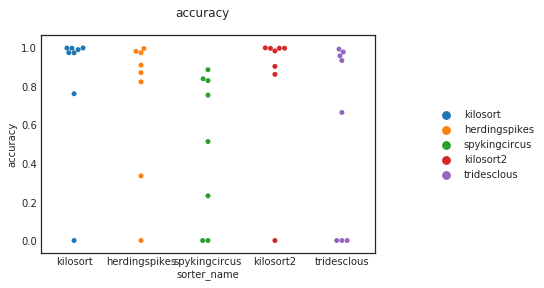

In [5]:
perfs = dataframes['perf_by_spiketrain'].reset_index()
fig, ax = plt.subplots()
g = sns.swarmplot(data=perfs, x='sorter_name', y='accuracy', hue='sorter_name', ax=ax)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
fig.suptitle('accuracy')

Text(0.5,0.98,'recall')

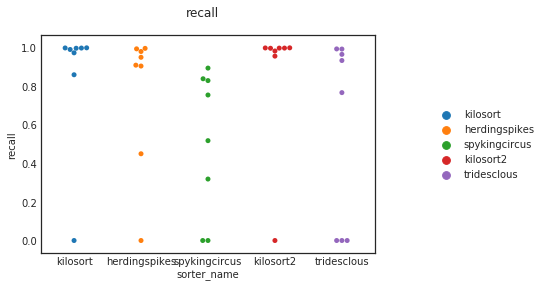

In [6]:
perfs = dataframes['perf_by_spiketrain'].reset_index()
fig, ax = plt.subplots()
g = sns.swarmplot(data=perfs, x='sorter_name', y='recall', hue='sorter_name', ax=ax)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
fig.suptitle('recall')

Text(0.5,0.98,'precision')

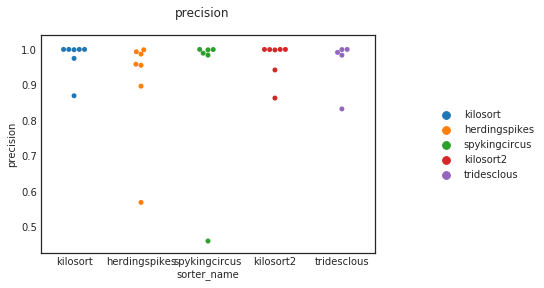

In [10]:
perfs = dataframes['perf_by_spiketrain'].reset_index()
fig, ax = plt.subplots()
g = sns.swarmplot(data=perfs, x='sorter_name', y='precision', hue='sorter_name', ax=ax)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
fig.suptitle('precision')

Text(0.5,0.98,'false_discovery_rate')

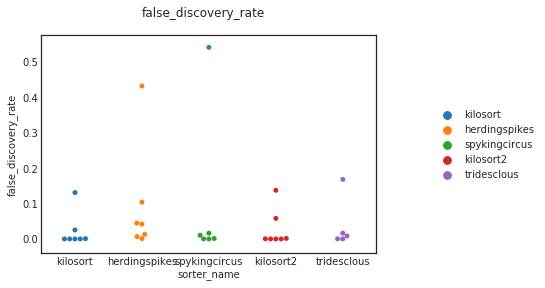

In [11]:
perfs = dataframes['perf_by_spiketrain'].reset_index()
fig, ax = plt.subplots()
g = sns.swarmplot(data=perfs, x='sorter_name', y='false_discovery_rate', hue='sorter_name', ax=ax)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
fig.suptitle('false_discovery_rate')

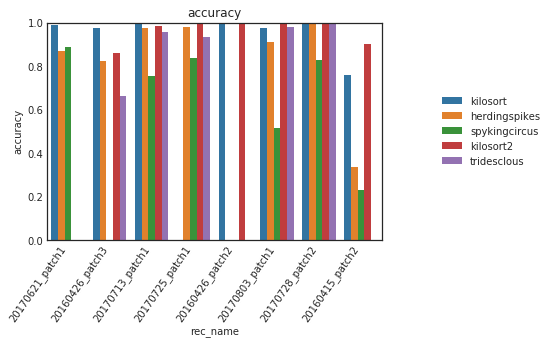

In [12]:
perfs = dataframes['perf_by_spiketrain'].reset_index()
fig, ax = plt.subplots()
sns.barplot(data=perfs, x='rec_name', y='accuracy', hue='sorter_name', ax=ax)
ax.set_title('accuracy')
ax.set_ylim(0, 1.)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
r = plt.setp(ax.xaxis.get_majorticklabels(), rotation=55, ha='right')

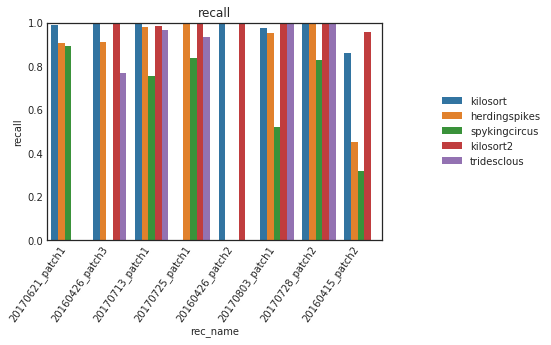

In [9]:
fig, ax = plt.subplots()
sns.barplot(data=perfs, x='rec_name', y='recall', hue='sorter_name', ax=ax)
ax.set_title('recall')
ax.set_ylim(0, 1.)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
r = plt.setp(ax.xaxis.get_majorticklabels(), rotation=55, ha='right')

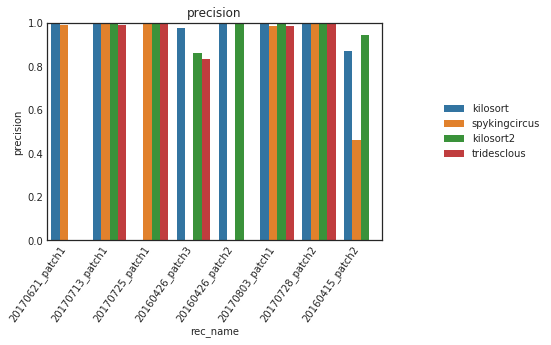

In [9]:
fig, ax = plt.subplots()
sns.barplot(data=perfs, x='rec_name', y='precision', hue='sorter_name', ax=ax)
ax.set_title('precision')
ax.set_ylim(0, 1.)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
r = plt.setp(ax.xaxis.get_majorticklabels(), rotation=55, ha='right')

# Accuracy vs peak amplitude SNR

In [10]:
# inject in snr in perf tables
perfs_snr = perfs.copy()
perfs_snr['snr'] = None
for rec_name in rec_names:
    peak_snr = gt_info.loc[rec_name, 'peak_snr']
    perfs_snr.loc[perfs_snr['rec_name']==rec_name, 'snr'] = peak_snr


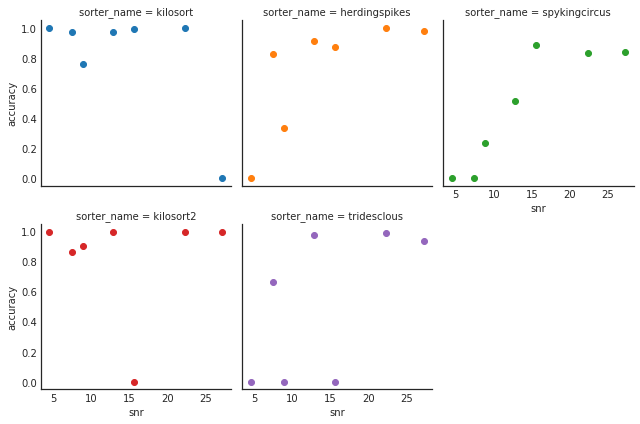

In [11]:
grid = sns.FacetGrid(perfs_snr, hue='sorter_name', col='sorter_name', col_wrap=3)
grid.map(plt.plot, 'snr', 'accuracy', marker="o", ls='None')


# Count how many well detected units


In dataframes['count_units'] we can check how many units in ground truth, in the tested sorter.
And also *"how many weel detected"* which means settings some threholds and criteria.


By default well detected units is for **accuracy>0.95** which is very strict.
This can be explore with other thresholds.



In [12]:
# dataframes = aggregate_performances_table(study_folder, accuracy=0.9)
dataframes['count_units'][['num_well_detected']].reset_index().sort_values(by=['sorter_name', 'rec_name'])

/home/samuel/Documents/projet/spikeinterface/spiketoolkit/spiketoolkit/comparison/groundtruthcomparison.py:317: RuntimeWarning: invalid value encountered in long_scalars
  perf['precision'] = tp / (tp + fp)
/home/samuel/Documents/projet/spikeinterface/spiketoolkit/spiketoolkit/comparison/groundtruthcomparison.py:318: RuntimeWarning: invalid value encountered in long_scalars
  perf['false_discovery_rate'] = fp / (tp + fp)


,rec_name,sorter_name,num_well_detected
20,20160415_patch2,herdingspikes,0.0
21,20160426_patch2,herdingspikes,0.0
3,20160426_patch3,herdingspikes,0.0
15,20170621_patch1,herdingspikes,0.0
39,20170713_patch1,herdingspikes,1.0
5,20170725_patch1,herdingspikes,1.0
37,20170728_patch2,herdingspikes,1.0
29,20170803_patch1,herdingspikes,1.0
26,20160415_patch2,kilosort,0.0
12,20160426_patch2,kilosort,1.0


In [ ]:
df = dataframes['count_units'].group_by('sorter_name')['num_well_detected'].sum()
sns.barplot(df)

# Count how many redundant units

Some sorter have the following pathology :  detecting a units twice or more!!!
This is particulary true for template matching sorters because they have internally a redundant dictionary.
We can measure this by counting how many units match the ground truth axcept the best one.


In [13]:
dataframes['count_units'][['num_redundant']].reset_index().sort_values(by=['sorter_name', 'rec_name'])

,rec_name,sorter_name,num_redundant
21,20160415_patch2,kilosort,0.0
10,20160426_patch2,kilosort,0.0
29,20160426_patch3,kilosort,0.0
2,20170621_patch1,kilosort,0.0
3,20170713_patch1,kilosort,0.0
5,20170725_patch1,kilosort,0.0
15,20170728_patch2,kilosort,0.0
25,20170803_patch1,kilosort,0.0
18,20160415_patch2,kilosort2,0.0
23,20160426_patch2,kilosort2,0.0
